In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping

from darts import TimeSeries
from darts.models import *
from darts.metrics import rmse, coefficient_of_variation
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from time_series_model.data.weather.weather_dataloader import MeteostatDataLoader
from time_series_model.data.data_loading import SMARDDataLoader
from time_series_model.evaluation_method import get_covariate_args, cross_validation_without_refit

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("time_series_model").setLevel(logging.INFO)
logging.getLogger('lightning').setLevel(0)
logging.getLogger('pytorch_lightning').setLevel(0)
logging.getLogger('darts').setLevel(0)
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

/home/jhoffbauer/hpi-porsche-challenge/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

### Load the weather data

In [3]:
meteostat_data_loader = MeteostatDataLoader(
    file_paths=[
        'data/raw/weather_data_solar_stations.csv'
    ],
    solar=True,
    wind=True
)
meteostat_data_loader.load_data()
weather_data = meteostat_data_loader.data

print("Missing values")
for col in weather_data.columns:
    print(f"  Column {col} has {weather_data[col].isna().mean() * 100:0.2f}% missing values")

weather_data['time'] = pd.to_datetime(weather_data['time'])
weather_data = weather_data.set_index('time')
print(f"Weather data index: {weather_data.index.min()} - {weather_data.index.max()}")

weather_data = TimeSeries.from_dataframe(
    weather_data, 
    value_cols=list(weather_data.columns), 
    fill_missing_dates=True, 
    fillna_value=0, 
    freq='1H'
)
# To float32
weather_data = weather_data.astype(np.float32)

2023-11-30 18:18:08,753 - time_series_model.data.weather.weather_dataloader - INFO - Initiating data loading process...
2023-11-30 18:18:08,804 - time_series_model.data.weather.weather_dataloader - INFO - Data loaded with 77929 rows and 12 columns.
2023-11-30 18:18:08,805 - time_series_model.data.weather.weather_dataloader - INFO - Data loading process completed successfully.


Missing values
  Column time has 0.00% missing values
  Column temp has 0.00% missing values
  Column dwpt has 0.00% missing values
  Column rhum has 0.00% missing values
  Column prcp has 0.00% missing values
  Column snow has 50.19% missing values
  Column wdir has 0.00% missing values
  Column wspd has 0.00% missing values
  Column wpgt has 34.62% missing values
  Column pres has 0.00% missing values
  Column tsun has 0.00% missing values
  Column coco has 18.97% missing values
Weather data index: 2015-01-01 00:00:00 - 2023-11-22 00:00:00


### Load SMARD data

In [4]:
smard_dataloader = SMARDDataLoader(
    file_paths=[
        'data/raw/2015_2016.csv',
        'data/raw/2017_2018.csv',
        'data/raw/2019_2020.csv',
        'data/raw/2021_2022.csv',
        'data/raw/2022_2023.csv'
    ]
)
smard_dataloader.load_data()
smard_dataloader.preprocess_data()
smard_dataloader.validate_data()

smard_data = smard_dataloader.data
smard_data['timestamp'] = pd.to_datetime(smard_data['timestamp'])
smard_data = smard_data.set_index('timestamp')
smard_data = TimeSeries.from_dataframe(
    smard_data, 
    value_cols=list(smard_data.columns), 
    fill_missing_dates=True, 
    fillna_value=0, 
    freq='1H'
)

2023-11-30 18:18:08,970 - time_series_model.data.data_loading - INFO - Initiating data loading process...
2023-11-30 18:18:09,133 - time_series_model.data.data_loading - INFO - Data loaded with 86448 rows and 15 columns.
2023-11-30 18:18:09,133 - time_series_model.data.data_loading - INFO - Data loading process completed successfully.
2023-11-30 18:18:09,134 - time_series_model.data.data_loading - INFO - Starting data preprocessing operations...
2023-11-30 18:18:09,134 - time_series_model.data.data_loading - INFO - Converting 'Datum' column to datetime format...
2023-11-30 18:18:09,423 - time_series_model.data.data_loading - INFO - Converted energy columns to float.
2023-11-30 18:18:09,519 - time_series_model.data.data_loading - INFO - Initial missing values in each column:
timestamp                  0
biomass_mwh               26
hydropower_mwh            26
wind_offshore_mwh         26
wind_onshore_mwh          26
photovoltaic_mwh          26
other_renewables_mwh      26
nuclear_mwh 

2023-11-30 18:18:09,570 - darts.timeseries - WARNING - Number of components is larger than 10 (11). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


<Axes: xlabel='time'>

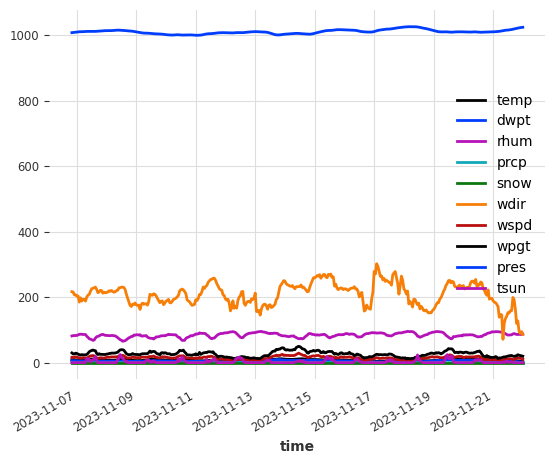

In [5]:
# Plot weather data
weather_data[-365:].plot()

### Create synthetic date-time covariates

In [6]:
weekday = datetime_attribute_timeseries(weather_data, attribute="weekday", dtype=np.float32)
month = datetime_attribute_timeseries(weather_data, attribute="month", dtype=np.float32)
hour = datetime_attribute_timeseries(weather_data, attribute="hour", dtype=np.float32)
covariates_time = weekday.stack(hour).stack(month)

scaler_covariates = Scaler()
covariates_time = scaler_covariates.fit_transform(
    covariates_time
)

Text(0.5, 1.0, 'Covariates Time')

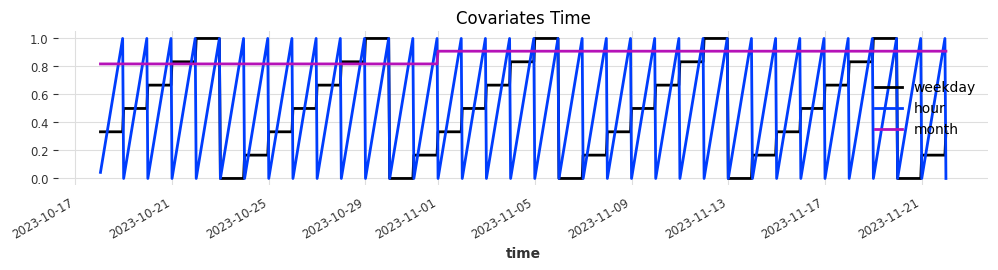

In [7]:
plt.figure(figsize=(12,2))
covariates_time[-5*7*24:].plot()
plt.title("Covariates Time")

### Train/Val/Test split for SMARD data

In [8]:
smard_data_scaler = Scaler()
scaled_smard_data = smard_data_scaler.fit_transform(smard_data)

test_split = 0.15
val_split = 0.15
train_end_index = (1 - val_split - test_split) * len(scaled_smard_data)
val_end_index = (1 - test_split) * len(scaled_smard_data)
train_end_index, val_end_index = int(train_end_index), int(val_end_index)

print(train_end_index, val_end_index)

train, val, test = scaled_smard_data[:train_end_index], scaled_smard_data[train_end_index:val_end_index], scaled_smard_data[val_end_index:]

# Cut train to start of weather data
train = train[weather_data.start_time():]

print("Train size: ", len(train))
print("Val size: ", len(val))
print("Test size: ", len(test))

print("Train time boundaries: ", train.start_time(), train.end_time(), len(train) / 24)
print("Val time boundaries: ", val.start_time(), val.end_time(), len(val) / 24)
print("Test time boundaries: ", test.start_time(), test.end_time(), len(test) / 24)

54381 66034
Train size:  54381
Val size:  11653
Test size:  11654
Train time boundaries:  2015-01-01 00:00:00 2021-03-15 20:00:00 2265.875
Val time boundaries:  2021-03-15 21:00:00 2022-07-14 09:00:00 485.5416666666667
Test time boundaries:  2022-07-14 10:00:00 2023-11-11 23:00:00 485.5833333333333


2023-11-30 18:18:14,524 - darts.timeseries - WARNING - Number of components is larger than 10 (12). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


Text(0.5, 1.0, 'Data')

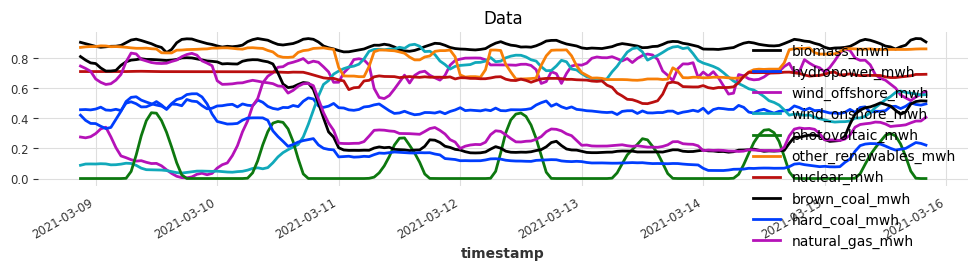

In [9]:
plt.figure(figsize=(12,2))
train[-24*7:].plot()
plt.title("Data")

## Model training

### LSTM

In [11]:
def fit_model(model):
    covariate_args = get_covariate_args(
        model=model,
        covariates=covariates_time.stack(weather_data),
    )[0]
    model.fit(series=train, val_series=val, **covariate_args)


def objective(trial):

    input_chunk_length = trial.suggest_int('input_chunk_length', 24, 24 * 7 * 4)
    hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    n_rnn_layers = trial.suggest_int('n_rnn_layers', 1, 3)
    n_epochs = 20

    print(f"Trialing with {trial.params}")

    my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs = {"callbacks": [my_stopper]}

    lstm_model = RNNModel(
        model="LSTM", 
        input_chunk_length=input_chunk_length, 
        training_length=input_chunk_length * 2,
        hidden_dim=hidden_dim, 
        dropout=dropout, 
        n_rnn_layers=n_rnn_layers,
        n_epochs=n_epochs,
        pl_trainer_kwargs=pl_trainer_kwargs,
        force_reset=True
    )

    fit_model(lstm_model)

    # Evaluate
    eval_result = cross_validation_without_refit(
        model=lstm_model,
        series=train.concatenate(val),
        start=val.start_time(),
        metrics=[rmse],
        data_scaler=smard_data_scaler,
        covariates=covariates_time.stack(weather_data),
        max_n_split=100,
        forecast_horizon=7*24,
        plotting=False
    ) 

    eval_rmse = eval_result['rmse']
    print(f"Eval RMSE: {eval_rmse}")

    return eval_rmse

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

[I 2023-11-25 20:55:11,552] A new study created in memory with name: no-name-205c4857-16fb-41ba-935e-4abebe0f38e0


Trialing with {'input_chunk_length': 56, 'hidden_dim': 64, 'dropout': 0.3812991039875482, 'n_rnn_layers': 3}
Epoch 5: 100%|██████████| 1696/1696 [00:14<00:00, 114.12it/s, train_loss=0.00649, val_loss=0.037] 


[I 2023-11-25 20:56:49,242] Trial 0 finished with value: 3819.333740234375 and parameters: {'input_chunk_length': 56, 'hidden_dim': 64, 'dropout': 0.3812991039875482, 'n_rnn_layers': 3}. Best is trial 0 with value: 3819.333740234375.


Eval RMSE: 3819.333740234375
Trialing with {'input_chunk_length': 34, 'hidden_dim': 64, 'dropout': 0.15159407089166582, 'n_rnn_layers': 1}
Epoch 5: 100%|██████████| 1698/1698 [00:13<00:00, 126.39it/s, train_loss=0.00765, val_loss=0.0123]


[I 2023-11-25 20:58:16,161] Trial 1 finished with value: 3456.127685546875 and parameters: {'input_chunk_length': 34, 'hidden_dim': 64, 'dropout': 0.15159407089166582, 'n_rnn_layers': 1}. Best is trial 1 with value: 3456.127685546875.


Eval RMSE: 3456.127685546875
Trialing with {'input_chunk_length': 253, 'hidden_dim': 32, 'dropout': 0.051561732933056714, 'n_rnn_layers': 3}
Epoch 5: 100%|██████████| 1684/1684 [00:17<00:00, 95.02it/s, train_loss=0.00843, val_loss=0.0165] 


[I 2023-11-25 21:00:09,054] Trial 2 finished with value: 2627.640625 and parameters: {'input_chunk_length': 253, 'hidden_dim': 32, 'dropout': 0.051561732933056714, 'n_rnn_layers': 3}. Best is trial 2 with value: 2627.640625.


Eval RMSE: 2627.640625
Trialing with {'input_chunk_length': 574, 'hidden_dim': 32, 'dropout': 0.08971396138799881, 'n_rnn_layers': 2}
Epoch 5: 100%|██████████| 1664/1664 [00:21<00:00, 78.78it/s, train_loss=0.00626, val_loss=0.0133]


[I 2023-11-25 21:02:22,651] Trial 3 finished with value: 2175.754150390625 and parameters: {'input_chunk_length': 574, 'hidden_dim': 32, 'dropout': 0.08971396138799881, 'n_rnn_layers': 2}. Best is trial 3 with value: 2175.754150390625.


Eval RMSE: 2175.754150390625
Trialing with {'input_chunk_length': 304, 'hidden_dim': 32, 'dropout': 0.37315543772004217, 'n_rnn_layers': 2}
Epoch 5: 100%|██████████| 1681/1681 [00:17<00:00, 97.77it/s, train_loss=0.00762, val_loss=0.0175] 


[I 2023-11-25 21:04:12,934] Trial 4 finished with value: 2922.30712890625 and parameters: {'input_chunk_length': 304, 'hidden_dim': 32, 'dropout': 0.37315543772004217, 'n_rnn_layers': 2}. Best is trial 3 with value: 2175.754150390625.


Eval RMSE: 2922.30712890625


In [13]:
best_params = study.best_params
print(f"Best params: {best_params}")

my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)
pl_trainer_kwargs = {"callbacks": [my_stopper]}

lstm_model = RNNModel(
    model="LSTM", 
    **best_params,
    n_epochs=20,
    training_length=best_params["input_chunk_length"] * 2,
    pl_trainer_kwargs=pl_trainer_kwargs,
    force_reset=True
)

fit_model(lstm_model)

# Evaluate
eval_result = cross_validation_without_refit(
    model=lstm_model,
    series=val.concatenate(test),
    start=test.start_time(),
    metrics=[rmse],
    data_scaler=smard_data_scaler,
    covariates=covariates_time.stack(weather_data),
    max_n_split=100,
    forecast_horizon=7*24,
    plotting=False
) 

eval_rmse = eval_result['rmse']
print(f"Eval RMSE: {eval_rmse}")

lstm_model.save("models/best_model.pkl")

Best params: {'input_chunk_length': 574, 'hidden_dim': 32, 'dropout': 0.08971396138799881, 'n_rnn_layers': 2}
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 5: 100%|██████████| 1664/1664 [00:21<00:00, 78.32it/s, train_loss=0.00571, val_loss=0.0117]
Eval RMSE: 2618.392333984375


### XGBoost

In [ ]:
def fit_model(model):
    covariate_args = get_covariate_args(
        model=model,
        covariates=covariates_time.stack(weather_data),
    )[0]
    model.fit(series=train, val_series=val, **covariate_args)


def objective(trial):

    max_depth = trial.suggest_int('max_depth', 5, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    lags = trial.suggest_int('lags', 24, 24 * 7 * 4)

    print(f"Trialing with {trial.params}")

    xgboost_model = XGBModel(
        max_depth=max_depth,
        n_estimators=n_estimators,
        lags=lags,
        lags_past_covariates=lags,
        verbosity=0,
    )

    fit_model(xgboost_model)

    # Evaluate
    eval_result = cross_validation_without_refit(
        model=xgboost_model,
        series=train.concatenate(val),
        start=val.start_time(),
        metrics=[rmse],
        data_scaler=smard_data_scaler,
        covariates=covariates_time.stack(weather_data),
        max_n_split=100,
        forecast_horizon=7*24,
        plotting=False
    ) 

    eval_rmse = eval_result['rmse']
    print(f"Eval RMSE: {eval_rmse}")

    return eval_rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

In [ ]:
best_params = {'max_depth': 9, 'n_estimators': 880, 'lags': 102} # study.best_params
print(f"Best params: {best_params}")

xgboost_model = XGBModel(**best_params)

fit_model(xgboost_model)

# Evaluate
eval_result = cross_validation_without_refit(
    model=xgboost_model,
    series=val.concatenate(test),
    start=test.start_time(),
    metrics=[rmse],
    data_scaler=smard_data_scaler,
    covariates=covariates_time.stack(weather_data),
    max_n_split=100,
    forecast_horizon=7*24,
    plotting=False
)

eval_rmse = eval_result['rmse']

xgboost_model.save("models/best_model_xgboost.pkl")

In [16]:
print(f"Best params: {best_params}")
print(f"Eval RMSE: {eval_rmse}")

Best params: {'max_depth': 9, 'n_estimators': 880, 'lags': 102}
Eval RMSE: 2511.30908203125
